In [79]:
#authenticator must be valid, check earth engine documentation
import ee
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

In [2]:
!python3 --version

Python 3.9.16


In [3]:
# !pip3 install -q odc.stac
# !pip3 install -q geopandas
# !pip3 install -q planetary_computer
# !pip3 install -q rioxarray
# !pip3 install -q loguru

In [4]:
# %load_ext lab_black
%load_ext autoreload
%autoreload 2

In [5]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import gc

import multiprocessing
from multiprocessing import Pool

%matplotlib inline

In [6]:
import geopy.distance as distance

# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]



In [7]:
DATA_DIR = ''

In [8]:
metadata = pd.read_csv(DATA_DIR + "metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [9]:
len(metadata.uid.unique())

23570

In [10]:
len(metadata.loc[:,['latitude','longitude' 	]].drop_duplicates())

12681

In [11]:
duplicated_rows=np.where(metadata.loc[:,['latitude','longitude' 	]].duplicated()==True)[0]
duplicated_rows

array([   79,   106,   107, ..., 23565, 23566, 23569])

In [12]:
metadata.iloc[duplicated_rows[0],:]

uid                acdj
latitude        37.3906
longitude      -120.958
date         2015-04-14
split             train
Name: 79, dtype: object

In [13]:
metadata.loc[metadata['latitude']==metadata.latitude.iloc[duplicated_rows[0]],:].head()

,uid,latitude,longitude,date,split
22,aaqc,37.3906,-120.958,2013-07-09,train
79,acdj,37.3906,-120.958,2015-04-14,train
1701,bxeq,37.3906,-120.958,2019-09-10,train
2302,conk,37.3906,-120.958,2019-12-04,train
2409,crja,37.3906,-120.958,2021-07-13,train


In [14]:
metadata.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [15]:
import geopandas as gpd
from shapely.geometry import Point

# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

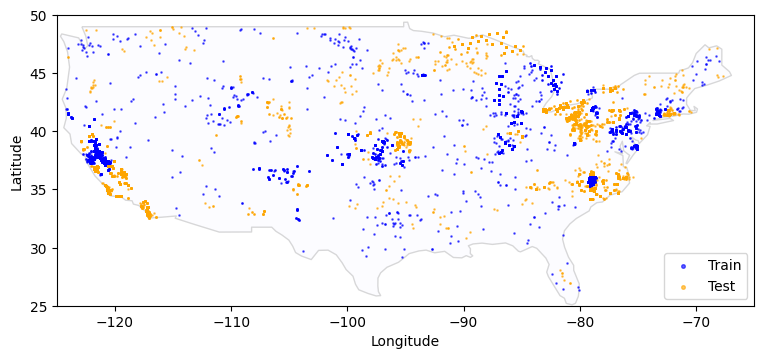

In [16]:
fig, ax = plt.subplots(figsize=(9, 4))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)
plt.show()

In [17]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


In [19]:
# # what years are in the data?
# pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
# plt.ylabel("Number of samples")
# plt.xlabel("Year")
# plt.title("Distribution of years in the data")
# plt.show()

In [20]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

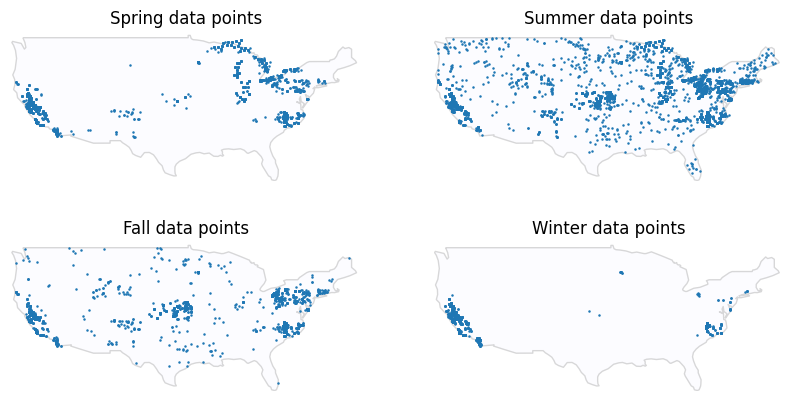

In [21]:
# where is data from for each season?
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

In [22]:
train_labels = pd.read_csv(DATA_DIR + "train_labels.csv")
train_labels.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [23]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

Text(0.5, 1.0, 'Train labels severity level counts')

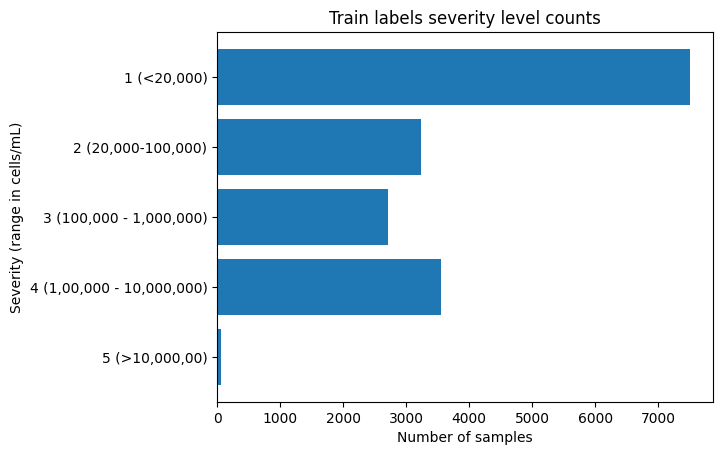

In [24]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

In [25]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

In [26]:
(train_labels.density == 0).sum()

91

In [27]:
submission_format = pd.read_csv(DATA_DIR + "submission_format.csv", index_col=0)
submission_format.head()

,region,severity
uid,,
aabn,west,1
aair,west,1
aajw,northeast,1
aalr,midwest,1
aalw,west,1


In [28]:
submission_format.shape

(6510, 2)

In [29]:
# # Fetch a Landsat image.
# img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# # Select Red and NIR bands, scale them, and sample 500 points.
# samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# # Arrange the sample as a list of lists.
# samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
# samp_list = ee.List(samp_dict.get('list'))

# # Save server-side ee.List as a client-side Python list.
# samp_data = samp_list.getInfo()

# # Display a scatter plot of Red-NIR sample pairs using matplotlib.
# plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
# plt.xlabel('Red', fontsize=12)
# plt.ylabel('NIR', fontsize=12)
# plt.show()

In [30]:
# Import the MODIS land cover collection.
S2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

In [31]:
#  Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = S2.select('B2').filterDate(i_date, f_date)

In [32]:
# Define the urban location of interest as a point near Lyon, France.
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)

In [33]:
scale = 1000  # scale in meters

lst_urban_point = lst.mean().sample(u_poi, scale).first().get('B2').getInfo()


In [34]:
lst_urban_point

4138.523529411765

In [35]:
lst.toArray().sample(u_poi, scale).first().get('B2').getInfo()

In [36]:
# ee.Geometry.Polygon()

In [37]:
AOI = ee.Geometry.Point(-122.269, 45.701)
START_DATE = '2020-06-01'
END_DATE = '2020-06-02'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50


In [38]:
ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_HARMONIZED') 
                       .filterBounds(AOI) 
                       .filterDate(ee.Date('2020-08-01'), ee.Date('2020-08-31')) 
                       .first() 
                       .clip(AOI))
ffa_db.getDownloadURL(),ffa_db.select(['B4','B3','B2']).getThumbURL(),ffa_db.select('B4').getThumbURL({'min': -20, 'max': 0})

('https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5f1f8e9140fdd0b304d96f8ac58a3bab-d23035c4547cc2bef72d8d4340556155:getPixels',
 'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15582543792ba587a1a9b11bcc2d0a06-3dcf99888817bdaa09f5bf9146c72738:getPixels',
 'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/972fcf30df8774a3f4d0ec71dc10237b-5d20c4874f6b4792ace707a1735319ec:getPixels')

In [39]:
metadata.loc[metadata.date==metadata.date.max(),:]


,uid,latitude,longitude,date,split,season
6540,hfvr,36.7962,-121.782,2021-12-29,test,winter
6864,howu,36.7085,-121.749,2021-12-29,test,winter
12443,nsoi,36.7368,-121.734,2021-12-29,test,winter
14254,prfi,36.7518,-121.742,2021-12-29,test,winter
17452,teuu,36.7723,-121.788,2021-12-29,test,winter
17559,thki,36.7254,-121.730,2021-12-29,test,winter


In [57]:
num=654
lat=metadata.latitude.iloc[num]
long=metadata.longitude.iloc[num]

In [58]:
bbox = get_bounding_box(lat, long, meter_buffer=500)
polygon=[
    [bbox[0],bbox[1]],
    [bbox[0],bbox[3]],
    [bbox[2],bbox[3]],
    [bbox[2],bbox[1]],
    [bbox[0],bbox[1]],
]
bbox,polygon

([-79.02243206648306,
  35.789493674487986,
  -79.01136982515753,
  35.79850632212748],
 [[-79.02243206648306, 35.789493674487986],
  [-79.02243206648306, 35.79850632212748],
  [-79.01136982515753, 35.79850632212748],
  [-79.01136982515753, 35.789493674487986],
  [-79.02243206648306, 35.789493674487986]])

In [59]:
# polygon = [[[-120.192, 37.494],
#       [-122.086, 37.418],
#       [-122.079, 37.425],
#       [-122.185, 37.493]]]
AOI=ee.Geometry.Polygon(polygon)
# ffa_db = ee.Image(ee.ImageCollection('LANDSAT/LC09/C02/T2') 
# ffa_db = ee.Image(ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') 
ffa_db = ee.Image(ee.ImageCollection('LANDSAT/LC08/C01/T1') 
                       .filterBounds(AOI) 
                       .filterDate(ee.Date('2019-08-01'), ee.Date('2020-10-31'))
                       .filter('CLOUD_COVER < 30')
#                        .select('B2', 'B3', 'B4', 'B8')
                       .sort('system:time_start', False)
                       .first() 
                       .clip(AOI)
                 )
# ffa_db.select(['B4','B3','B2']).getThumbURL({'min': -20, 'max': 0})
print(ffa_db.select(['B2','B3','B4']).getThumbURL({'min': 0, 'max': 1000}))
# ffa_db.select(['B4','B3','B2']).getVideoThumbURL()
# ffa_db.getDownloadURL()
url=ffa_db.getDownloadURL()

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2cbec7b77e4f22b05ff0469820c1e6f5-6961bc56b74e76afaf0d0ed8a1512f5b:getPixels


In [60]:
# ffa_db.se

In [61]:
url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1b501dbd188ea2402cb810de5287dcc0-e2a968a84f42a926409416c28c9af4be:getPixels'

In [62]:
# polygon = [[[-120.192, 37.494],
#       [-122.086, 37.418],
#       [-122.079, 37.425],
#       [-122.185, 37.493]]]
AOI=ee.Geometry.Polygon(polygon)
ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') 
                       .filterBounds(AOI) 
                       .filterDate(ee.Date('2019-08-01'), ee.Date('2020-08-31'))
                       .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 30)
#                        .select('B2', 'B3', 'B4', 'B8')
                       .sort('system:time_start', False)
                       .first() 
                       .clip(AOI))
# ffa_db.select(['B4','B3','B2']).getThumbURL({'min': -20, 'max': 0})
ffa_db.select(['B2','B3','B4']).getThumbURL({'min': 0, 'max': 1000})
# ffa_db.select(['B4','B3','B2']).getVideoThumbURL()
# ffa_db.getDownloadURL()

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/32708e01d0a93e5be6b98ca02bd08ec2-011dc0b0c52dd525b9bfecdf1d083eed:getPixels'

In [63]:
url=ffa_db.getDownloadURL()
url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9b2d1c88c58d8fb154298ee9722135aa-163cadc549a4ec9008b1e12facd60bce:getPixels'

In [64]:
import requests, tempfile, zipfile, os
from io import StringIO, BytesIO
r = requests.get(f"{url}")
resp = requests.get(url, stream=True)

# file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)
# with file as f:
#     f.write(resp.content)

file='EEtemp/f13/'    
z = zipfile.ZipFile(BytesIO(r.content))
z.extractall(file)    

In [65]:
os.listdir(file)

['20200826T155829_20200826T160543_T17SPV.B11.tif',
 '20200827T184919_20200827T185937_T10SFF.QA20.tif',
 '20200826T155829_20200826T160543_T17SPV.MSK_CLDPRB.tif',
 '20200827T184919_20200827T185937_T10SFF.TCI_G.tif',
 '20200826T155829_20200826T160543_T17SPV.B12.tif',
 '20200827T184919_20200827T185937_T10SFF.SCL.tif',
 '20200827T184919_20200827T185937_T10SFF.MSK_CLDPRB.tif',
 '20200827T184919_20200827T185937_T10SFF.B6.tif',
 '20200826T155829_20200826T160543_T17SPV.B8A.tif',
 '20200827T184919_20200827T185937_T10SFF.B2.tif',
 '20200826T155829_20200826T160543_T17SPV.QA10.tif',
 '20200827T184919_20200827T185937_T10SFF.TCI_R.tif',
 '20200826T155829_20200826T160543_T17SPV.B8.tif',
 '20200827T184919_20200827T185937_T10SFF.B4.tif',
 '20200827T184919_20200827T185937_T10SFF.B9.tif',
 '20200826T155829_20200826T160543_T17SPV.B9.tif',
 '20200826T155829_20200826T160543_T17SPV.MSK_SNWPRB.tif',
 '20200827T184919_20200827T185937_T10SFF.WVP.tif',
 '20200827T184919_20200827T185937_T10SFF.TCI_B.tif',
 '202008

In [66]:
# [x for x in os.listdir(file) if x[-6:-4] in ['B4','B3', 'B2']]
im=[x for x in os.listdir(file) if x.split('.')[1] in ['B4','B3', 'B2']]
im0=os.listdir(file)[0].split('.')[0]
im,im0

(['20200827T184919_20200827T185937_T10SFF.B2.tif',
  '20200827T184919_20200827T185937_T10SFF.B4.tif',
  '20200826T155829_20200826T160543_T17SPV.B2.tif',
  '20200826T155829_20200826T160543_T17SPV.B3.tif',
  '20200826T155829_20200826T160543_T17SPV.B4.tif',
  '20200827T184919_20200827T185937_T10SFF.B3.tif'],
 '20200826T155829_20200826T160543_T17SPV')

In [67]:
# B4=cv2.imread(file+im0+'.B6'+'.tif', cv2.IMREAD_GRAYSCALE)
# B4.shape,B4.min(),B4.max()

In [68]:
# plt.imshow(B4)
# plt.show()

In [69]:
import rasterio
def read_band(path,band='B4'):
    im0=os.listdir(path)[0].split('.')[0]
    b=rasterio.open(path+im0+'.'+band+'.tif' ).read()[0,...]
#     percB = np.percentile(b,[0.1,99.99])
#     b = np.clip(b, percB[0], percB[1])
    B=(((b-b.min())/(b.max()-b.min()))*255).astype('uint8')
    return(B)
    

b4=rasterio.open(file+im0+'.B4'+'.tif' ).read()[0,...]
b4.min(),b4.max()
B4=(((b4-b4.min())/(b4.max()-b4.min()))*255).astype('uint8')

In [70]:
B4=read_band(file,band='B4')
B3=read_band(file,band='B3')
B2=read_band(file,band='B2')
RGB=np.stack((B2,B3,B4),-1)
RGB.shape

(103, 103, 3)

In [71]:
# b4#.shape
np.percentile(B4,[1,99])
# B4

array([ 0.  , 98.92])

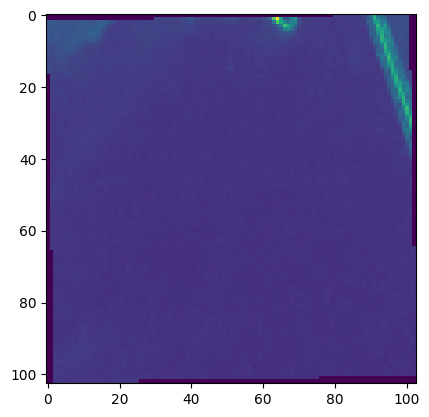

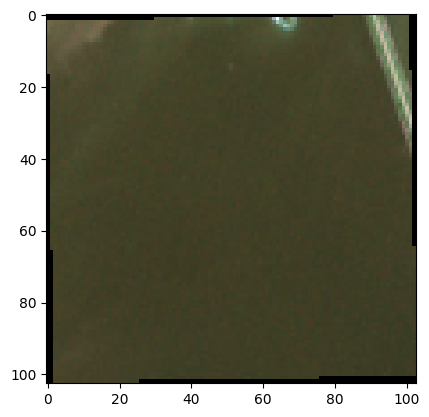

In [72]:
# plt.imshow((RGB.astype(float)**1.05).astype('uint8'))
# plt.show()
plt.imshow(B4)
plt.show()
plt.imshow(RGB)
plt.show()

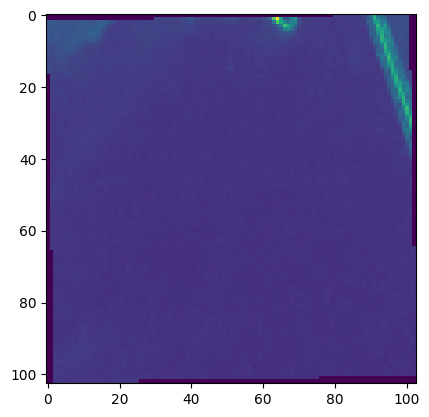

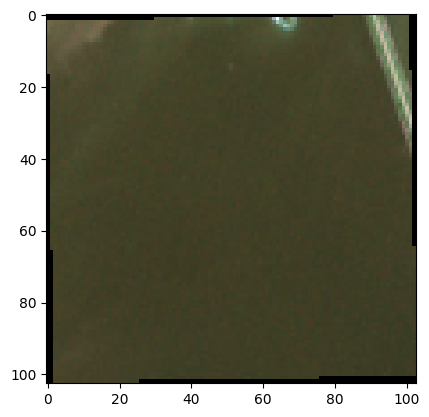

In [73]:
plt.imshow(B4)
plt.show()
plt.imshow(RGB)
plt.show()

In [74]:
metadata

,uid,latitude,longitude,date,split,season
0,aabm,39.080319,-86.430867,2018-05-14,train,spring
1,aabn,36.559700,-121.510000,2016-08-31,test,summer
2,aacd,35.875083,-78.878434,2020-11-19,train,fall
3,aaee,35.487000,-79.062133,2016-08-24,train,summer
4,aaff,38.049471,-99.827001,2019-07-23,train,summer
...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,winter
23566,zzwo,39.792190,-99.971050,2017-06-19,train,summer
23567,zzwq,35.794000,-79.012551,2015-03-24,train,spring
23568,zzyb,35.742000,-79.238600,2016-11-21,train,fall


In [75]:
# # metadata.dtypes
# undate = metadata.date[0].date()
# # for undate in undates:
# def single_date(undate):
#     try:
#         DB=[]
#         for days_before in range(NUM_DAYS_BEFORE):
#             date = undate -timedelta(days_before)


In [76]:
str(metadata.loc[metadata.uid=='aabm','date'].iloc[0].date())
# ee.Date(str(metadata.loc[metadata.uid=='aabm','date'].iloc[0].date()))
END_DATE=metadata.loc[metadata.uid=='aabm','date'].iloc[0].date()
time_buffer_days=20
START_DATE=END_DATE-timedelta(days=time_buffer_days)
str(START_DATE), str(END_DATE)

('2018-04-24', '2018-05-14')

In [77]:
# plt.imshow(B4)
# plt.show()
# plt.imshow(RGB)
# plt.show()
import datetime
# str(datetime.date(metadata.loc[metadata.uid=='aabm',['date']].date))
ee.Date('2019-08-01')

In [65]:
START_DATE, END_DATE

(datetime.date(2018, 4, 24), datetime.date(2018, 5, 14))

In [66]:
#get the most recent image inbetween dates
TIME_BUFFER_DAYS=20
AREA_BUFFER = 500
CLOUDS_LESS_THAN=30

BASE_DIRs = 'EEtemp/S_t'+str(TIME_BUFFER_DAYS)+'_a'+str(AREA_BUFFER)+'_c'+str(CLOUDS_LESS_THAN)+'/'
BASE_DIRl = 'EEtemp/L_t'+str(TIME_BUFFER_DAYS)+'_a'+str(AREA_BUFFER)+'_c'+str(CLOUDS_LESS_THAN)+'/'
isExist = os.path.exists(BASE_DIRs)
if not isExist:
    os.makedirs(BASE_DIRs)
isExist = os.path.exists(BASE_DIRl)
if not isExist:
    os.makedirs(BASE_DIRl)
    
# for uid in metadata.uid:
def get_sentinel(START_DATE, END_DATE, AOI):

    # ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') 
    ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_HARMONIZED') 
                           .filterBounds(AOI) 
                           .filterDate(ee.Date(START_DATE), ee.Date(END_DATE))
                           .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', CLOUDS_LESS_THAN)
    #                        .select('B2', 'B3', 'B4', 'B8')
                           .sort('system:time_start', False)
                           .first() 
                           .clip(AOI))
    url=ffa_db.getDownloadURL()
    return url
def get_landsat(START_DATE, END_DATE, AOI):

    # ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') 
    ffa_db = ee.Image(ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') 
                           .filterBounds(AOI) 
                           .filterDate(ee.Date(START_DATE), ee.Date(END_DATE))
                           .filter('CLOUD_COVER < '+str(CLOUDS_LESS_THAN))
    #                        .select('B2', 'B3', 'B4', 'B8')
                           .sort('system:time_start', False)
                           .first() 
                           .clip(AOI))
    url=ffa_db.getDownloadURL()
    return url

def get_satellites(uid):
    # uid=metadata.uid.iloc[1]
    lat=metadata.latitude.loc[metadata.uid==uid].values[0]
    long=metadata.longitude.loc[metadata.uid==uid].values[0]

    END_DATE=metadata.loc[metadata.uid=='aabm','date'].iloc[0].date()
    START_DATE=END_DATE-timedelta(days=TIME_BUFFER_DAYS)
    START_DATE, END_DATE = str(START_DATE), str(END_DATE)

    bbox = get_bounding_box(lat, long, meter_buffer=AREA_BUFFER)
    polygon=[       [bbox[0],bbox[1]],
                    [bbox[0],bbox[3]],
                    [bbox[2],bbox[3]],
                    [bbox[2],bbox[1]],
                    [bbox[0],bbox[1]]  ]
    AOI=ee.Geometry.Polygon(polygon)

    try:
        url=get_sentinel(START_DATE, END_DATE, AOI)
        r = requests.get(f"{url}")

        file=BASE_DIRs+uid+'/'    
        z = zipfile.ZipFile(BytesIO(r.content))
        z.extractall(file)    
    except:
        pass
    
    try:    
        url=get_landsat(START_DATE, END_DATE, AOI)
        r = requests.get(f"{url}")

        file=BASE_DIRl+uid+'/'    
        z = zipfile.ZipFile(BytesIO(r.content))
        z.extractall(file)    
    except:
        pass
    
    
# get_satellites(metadata.uid.iloc[1])    

In [72]:
#get the oldest image inbetween dates
# TIME_BUFFER_DAYS=20
# AREA_BUFFER = 500
# CLOUDS_LESS_THAN=30

# BASE_DIRs = 'EEtemp/S_t'+str(TIME_BUFFER_DAYS)+'_a'+str(AREA_BUFFER)+'_c'+str(CLOUDS_LESS_THAN)+'first/'
# BASE_DIRl = 'EEtemp/L_t'+str(TIME_BUFFER_DAYS)+'_a'+str(AREA_BUFFER)+'_c'+str(CLOUDS_LESS_THAN)+'first/'
# isExist = os.path.exists(BASE_DIRs)
# if not isExist:
#     os.makedirs(BASE_DIRs)
# isExist = os.path.exists(BASE_DIRl)
# if not isExist:
#     os.makedirs(BASE_DIRl)
    
# # for uid in metadata.uid:
# def get_sentinel(START_DATE, END_DATE, AOI):

#     ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') 
# #     ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_HARMONIZED') 
#                            .filterBounds(AOI) 
#                            .filterDate(ee.Date(START_DATE), ee.Date(END_DATE))
#                            .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', CLOUDS_LESS_THAN)
#     #                        .select('B2', 'B3', 'B4', 'B8')
# #                            .sort('system:time_start', False)
#                            .first() 
#                            .clip(AOI))
#     url=ffa_db.getDownloadURL()
#     return url
# def get_landsat(START_DATE, END_DATE, AOI):

#     # ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') 
#     ffa_db = ee.Image(ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') 
#                            .filterBounds(AOI) 
#                            .filterDate(ee.Date(START_DATE), ee.Date(END_DATE))
#                            .filter('CLOUD_COVER < '+str(CLOUDS_LESS_THAN))
#     #                        .select('B2', 'B3', 'B4', 'B8')
# #                            .sort('system:time_start', False)
#                            .first() 
#                            .clip(AOI))
#     url=ffa_db.getDownloadURL()
#     return url

# def get_satellites(uid):
#     # uid=metadata.uid.iloc[1]
#     lat=metadata.latitude.loc[metadata.uid==uid].values[0]
#     long=metadata.longitude.loc[metadata.uid==uid].values[0]

#     END_DATE=metadata.loc[metadata.uid=='aabm','date'].iloc[0].date()
#     START_DATE=END_DATE-timedelta(days=TIME_BUFFER_DAYS)
#     START_DATE, END_DATE = str(START_DATE), str(END_DATE)

#     bbox = get_bounding_box(lat, long, meter_buffer=AREA_BUFFER)
#     polygon=[       [bbox[0],bbox[1]],
#                     [bbox[0],bbox[3]],
#                     [bbox[2],bbox[3]],
#                     [bbox[2],bbox[1]],
#                     [bbox[0],bbox[1]]  ]
#     AOI=ee.Geometry.Polygon(polygon)

#     try:
#         url=get_sentinel(START_DATE, END_DATE, AOI)
#         r = requests.get(f"{url}")

#         file=BASE_DIRs+uid+'/'    
#         z = zipfile.ZipFile(BytesIO(r.content))
#         z.extractall(file)    
#     except:
#         pass
    
#     try:    
#         url=get_landsat(START_DATE, END_DATE, AOI)
#         r = requests.get(f"{url}")

#         file=BASE_DIRl+uid+'/'    
#         z = zipfile.ZipFile(BytesIO(r.content))
#         z.extractall(file)    
#     except:
#         pass
    
    
# # get_satellites(metadata.uid.iloc[1])    

In [68]:
#get the Level1 image inbetween dates
# TIME_BUFFER_DAYS=20
# AREA_BUFFER = 500
# # AREA_BUFFER = 100
# CLOUDS_LESS_THAN=30

# BASE_DIRs = 'EEtemp/S_t'+str(TIME_BUFFER_DAYS)+'_a'+str(AREA_BUFFER)+'_c'+str(CLOUDS_LESS_THAN)+'Level1/'
# BASE_DIRl = 'EEtemp/L_t'+str(TIME_BUFFER_DAYS)+'_a'+str(AREA_BUFFER)+'_c'+str(CLOUDS_LESS_THAN)+'Tier1/'
# isExist = os.path.exists(BASE_DIRs)
# if not isExist:
#     os.makedirs(BASE_DIRs)
# isExist = os.path.exists(BASE_DIRl)
# if not isExist:
#     os.makedirs(BASE_DIRl)
    
# # for uid in metadata.uid:
# def get_sentinel(START_DATE, END_DATE, AOI):

#     # ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') 
#     ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_HARMONIZED') 
#                            .filterBounds(AOI) 
#                            .filterDate(ee.Date(START_DATE), ee.Date(END_DATE))
#                            .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', CLOUDS_LESS_THAN)
#     #                        .select('B2', 'B3', 'B4', 'B8')
#                            .sort('system:time_start', False)
#                            .first() 
#                            .clip(AOI))
#     url=ffa_db.getDownloadURL()
#     return url
# def get_landsat(START_DATE, END_DATE, AOI):

#     # ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') 
#     ffa_db = ee.Image(ee.ImageCollection('LANDSAT/LC08/C01/T1') 
#                            .filterBounds(AOI) 
#                            .filterDate(ee.Date(START_DATE), ee.Date(END_DATE))
#                            .filter('CLOUD_COVER < '+str(CLOUDS_LESS_THAN))
#     #                        .select('B2', 'B3', 'B4', 'B8')
#                            .sort('system:time_start', False)
#                            .first() 
#                            .clip(AOI))
#     url=ffa_db.getDownloadURL()
#     return url

# def get_satellites(uid):
#     # uid=metadata.uid.iloc[1]
#     lat=metadata.latitude.loc[metadata.uid==uid].values[0]
#     long=metadata.longitude.loc[metadata.uid==uid].values[0]

#     END_DATE=metadata.loc[metadata.uid=='aabm','date'].iloc[0].date()
#     START_DATE=END_DATE-timedelta(days=TIME_BUFFER_DAYS)
#     START_DATE, END_DATE = str(START_DATE), str(END_DATE)

#     bbox = get_bounding_box(lat, long, meter_buffer=AREA_BUFFER)
#     polygon=[       [bbox[0],bbox[1]],
#                     [bbox[0],bbox[3]],
#                     [bbox[2],bbox[3]],
#                     [bbox[2],bbox[1]],
#                     [bbox[0],bbox[1]]  ]
#     AOI=ee.Geometry.Polygon(polygon)

#     try:
#         url=get_sentinel(START_DATE, END_DATE, AOI)
#         r = requests.get(f"{url}")

#         file=BASE_DIRs+uid+'/'    
#         z = zipfile.ZipFile(BytesIO(r.content))
#         z.extractall(file)    
#     except:
#         pass
    
#     try:    
#         url=get_landsat(START_DATE, END_DATE, AOI)
#         r = requests.get(f"{url}")

#         file=BASE_DIRl+uid+'/'    
#         z = zipfile.ZipFile(BytesIO(r.content))
#         z.extractall(file)    
#     except:
#         pass
    
    
# # get_satellites(metadata.uid.iloc[1])    

In [78]:
metadata.uid.values

array(['aabm', 'aabn', 'aacd', ..., 'zzwq', 'zzyb', 'zzzi'], dtype=object)

In [ ]:
import multiprocessing
from multiprocessing import Pool

pool = Pool(processes=8)
# for _ in tqdm(pool.imap_unordered(get_satellites, metadata.uid.values)):
for _ in tqdm(pool.imap_unordered(get_satellites, metadata.uid.values), total=len(metadata)):
    
    pass

 17%|█▋        | 4049/23570 [33:36<1:47:17,  3.03it/s] 

In [586]:
gc.collect()

49242

In [71]:
# s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
#         .filterBounds(AOI)
#         .filterDate(START_DATE, END_DATE)
#         .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))


In [81]:
# def add_cloud_bands(img):
#     # Get s2cloudless image, subset the probability band.
#     cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

#     # Condition s2cloudless by the probability threshold value.
#     is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

#     # Add the cloud probability layer and cloud mask as image bands.
#     return img.addBands(ee.Image([cld_prb, is_cloud]))
# def add_shadow_bands(img):
#     # Identify water pixels from the SCL band.
#     not_water = img.select('SCL').neq(6)

#     # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
#     SR_BAND_SCALE = 1e4
#     dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

#     # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
#     shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

#     # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
#     cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
#         .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
#         .select('distance')
#         .mask()
#         .rename('cloud_transform'))

#     # Identify the intersection of dark pixels with cloud shadow projection.
#     shadows = cld_proj.multiply(dark_pixels).rename('shadows')

#     # Add dark pixels, cloud projection, and identified shadows as image bands.
#     return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))
# def add_cld_shdw_mask(img):
#     # Add cloud component bands.
#     img_cloud = add_cloud_bands(img)

#     # Add cloud shadow component bands.
#     img_cloud_shadow = add_shadow_bands(img_cloud)

#     # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
#     is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

#     # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
#     # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
#     is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
#         .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
#         .rename('cloudmask'))

#     # Add the final cloud-shadow mask to the image.
#     return img_cloud_shadow.addBands(is_cld_shdw)
